# Training

In [1]:
import numpy as np
import tensorflow as tf
from IPython.display import clear_output

In [2]:
from shared import CAModel, imshow, zoom, to_rgb, to_rgba, load_emoji, CHANNEL_N, \
    SamplePool, make_circle_masks, generate_pool_figures, visualize_batch, plot_loss, \
    export_model, TRAIN_LOG_PATH

In [3]:
TARGET_EMOJI = "🦎" #@param {type:"string"}
POOL_SIZE = 1024
BATCH_SIZE = 8

DAMAGE_N = 3  # Number of patterns to damage in a batch
USE_PATTERN_POOL = 1

In [4]:
CAModel().dmodel.summary()

2021-09-01 15:59:23.470815: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 3, 3, 128)            6272      
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 3, 3, 16)             2064      
Total params: 8,336
Trainable params: 8,336
Non-trainable params: 0
_________________________________________________________________


2021-09-01 15:59:23.781219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


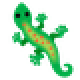

In [5]:
target_img = load_emoji(TARGET_EMOJI)
imshow(zoom(to_rgb(target_img), 2), fmt='png')

In [6]:
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
p = TARGET_PADDING
pad_target = tf.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:] = 1.0

def loss_f(x):
    return tf.reduce_mean(tf.square(to_rgba(x)-pad_target), [-2, -3, -1])

ca = CAModel()

loss_log = []

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.Adam(lr_sched)

loss0 = loss_f(seed).numpy()
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))

!mkdir -p {TRAIN_LOG_PATH} && rm -f {TRAIN_LOG_PATH}/*

batch (before/after):


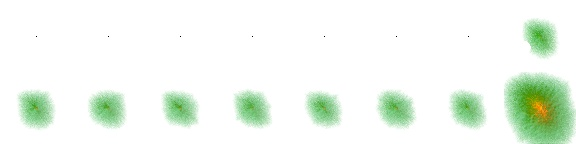

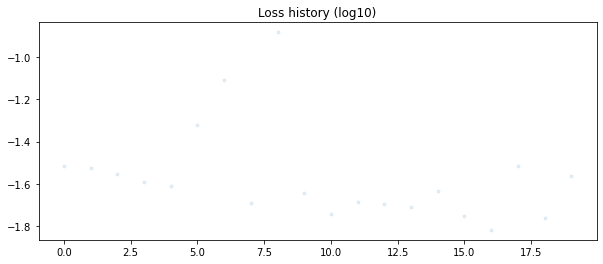

 step: 20, log10(loss): -1.562

2021-09-01 16:01:07.202241: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-09-01 16:01:07.202342: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-09-01 16:01:07.209560: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 104 nodes (56), 113 edges (58), time = 3.672ms.
  function_optimizer: function_optimizer did nothing. time = 0.208ms.



In [7]:
# @title Training Loop {vertical-output: true}

@tf.function
def train_step(x):
    iter_n = tf.random.uniform([], 64, 96, tf.int32)
    with tf.GradientTape() as g:
        for i in tf.range(iter_n):
            x = ca(x)
        loss = tf.reduce_mean(loss_f(x))
    grads = g.gradient(loss, ca.weights)
    grads = [g / (tf.norm(g) + 1e-8) for g in grads]
    trainer.apply_gradients(zip(grads, ca.weights))
    return x, loss


#FIGURE_EPOCHS = 10
FIGURE_EPOCHS = 1

#CHECKPOINT_EPOCHS = 100
CHECKPOINT_EPOCHS = 1

#STEPS = 8000
STEPS = 20

for i in range(STEPS):
    if USE_PATTERN_POOL:
        batch = pool.sample(BATCH_SIZE)
        x0 = batch.x
        loss_rank = loss_f(x0).numpy().argsort()[::-1]
        x0 = x0[loss_rank]
        x0[:1] = seed
        if DAMAGE_N:
            damage = 1.0 - make_circle_masks(DAMAGE_N, h, w).numpy()[..., None]
            x0[-DAMAGE_N:] *= damage
    else:
        x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

    x, loss = train_step(x0)

    if USE_PATTERN_POOL:
        batch.x[:] = x
        batch.commit()

    step_i = len(loss_log)
    loss_log.append(loss.numpy())

    if step_i % FIGURE_EPOCHS == 0:
        generate_pool_figures(pool, step_i)
    if step_i % CHECKPOINT_EPOCHS == 0:
        clear_output()
        visualize_batch(x0, x, step_i)
        plot_loss(loss_log)
        export_model(ca, f'{TRAIN_LOG_PATH}/%04d' % step_i)

    print('\r step: %d, log10(loss): %.3f' % (len(loss_log), np.log10(loss)), end='')